# 환경설정

버전 : python 3.7, tensorflow 2.3.0-rc0

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### 데이터 불러오기 <br>
우선 KBO 타자 데이터를 불러오도록 한다.

링크 : https://www.kaggle.com/bluemumin/kbo-baseball-for-kaggle/version/2

In [2]:
data_path = './2019_kbo_for_kaggle_v2.csv'

In [3]:
def load_data (data_path) :
    data = pd.read_csv(data_path)
    return data 

In [4]:
data = load_data(data_path)

In [5]:
data

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,포수,5.0,6.0,0.173,0.259,0.250,0.509,2014,79.0,0.580
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,포수,8.0,5.0,0.177,0.226,0.354,0.580,2015,154.0,0.784
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,포수,20.0,20.0,0.234,0.316,0.468,0.784,2016,174.0,0.581
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,포수,23.0,20.0,0.195,0.276,0.305,0.581,2017,17.0,0.476
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,포수,3.0,3.0,0.176,0.300,0.176,0.476,2018,47.0,0.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3루수,93.0,59.0,0.301,0.374,0.493,0.867,2019,395.0,0.768
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우익수,44.0,28.0,0.272,0.365,0.319,0.684,2018,13.0,0.154
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우익수,1.0,0.0,0.077,0.077,0.077,0.154,2019,188.0,0.720
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,3루수,57.0,16.0,0.312,0.344,0.505,0.849,2016,523.0,0.889


In [6]:
print(data.dtypes)


batter_name     object
age            float64
G              float64
PA             float64
AB             float64
R              float64
H              float64
2B             float64
3B             float64
HR             float64
TB             float64
RBI            float64
SB             float64
CS             float64
BB             float64
HBP            float64
GB             float64
SO             float64
GDP            float64
BU             float64
fly            float64
year             int64
salary           int64
war            float64
year_born       object
hand2           object
cp              object
tp              object
1B             float64
FBP            float64
avg            float64
OBP            float64
SLG            float64
OPS            float64
p_year           int64
YAB            float64
YOPS           float64
dtype: object


위 처럼 데이터를 모두 불러오는 데 성공하였다. <br> 
각 지표에 대한 설명은 아래와 같다.

- batter_name : 선수이름
- age : 나이
- G : 경기 수
- PA : 타수
- AB : 타석 수
- R : 득점
- H : 안타
    - 진루하지 못해도 공을 치기만 한 횟수
- 2B : 2루타
    - 한번 타수에 2루타를 진출한 횟수
- 3B : 3루타
    - 한번 타수에 3루타를 진출한 횟수
- HR : 홈런
- TB : 총 루타 수
    - 1루타 + 2*2루타 + 3*3루타 + 4*홈런
- RBI : 타점
- SB : 도루 성공
    - 베이스에 있는 주자가 공과 상관없이 다음 베이스로 가는 것을 성공함
- CS : 도루 실패
    - 베이스에 있는 주자가 공과 상관없이 다음 베이스로 가는 것을 실패함
- BB : 볼넷* 수
    - 볼넷 : 타자가 타석에서 4개의 볼 카운트를 얻어내 1루로 나가는 것
- HBP : 몸에 맞은 공(데드볼 맞은 횟수)
- GB : 고의4구
    - 마지막으로 던진 볼을 포수가 발을 빼서 서서 받으면 고의사구로 기록
    - 투수가 타자의 승부를 포기했다는 의사표시를 확실하게 구분하기 위해 별도 표기
- SO : 3진
- GDP : 병살
    - 미스플레이 없이 연속으로 아웃 카운트가 두 개 생기는 경우를 뜻하며, 그러한 수비에 참여한 수비수들에게 주어지는 기록
- BU : 희생타
    - 번트
    - 요즘 번트는 득점 가능성을 떨어뜨리는 공격수단이라고 주장
    - 번트가 유용한 경우는 타격능력이 떨어져 번트 이외의 방법으로 주자를 진루시킬 능력이 없는 타자
    - 경기 최후반 1점이라도 내면 승리를 확정지을 수 있는 상황에서 그 1점이 간절히 필요할 때
- fly : 희생 플라이(희비)
- year : 해당 시즌
- salary : 해당 시즌의 연봉
- war : 대체 선수 대비 승리 기여도
- year_born : 선수가 태어난 연도
- hand2 : 타석 위치
    - 좌투우타 : 수비는 왼손으로 던지나 타석은 오른쪽에서 함.
    - 우투우타 : 수비는 오른손으로 던지고 타석은 오른쪽에서 함.
    - 좌투좌타 : 수비는 왼손으로 던지고 타석도 왼쪽에서 함.
    - 우투좌타 : 수비는 오른손으로 던지나 타석은 왼쪽에서 함.
- cp : 최근 포지션
    - 해당 시즌에 선택한 포지션
- tp : 통합 포지션
    - 기본적인 포지션
    - 지명타자 : 투수 대신 나서는 타자
    - 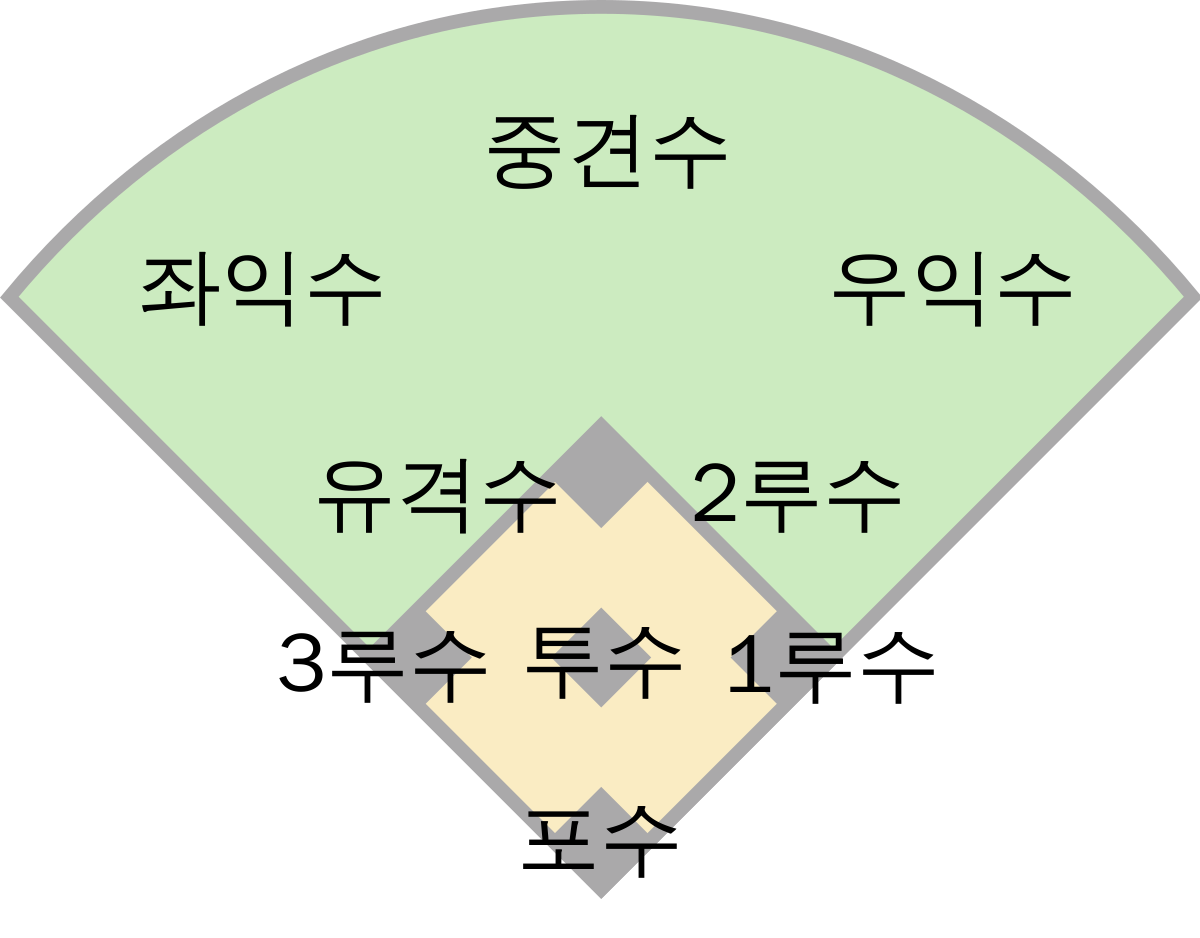
    
- 1B : 1루타
    - 한번 타수에 1루를 무사히 진출한 횟수
- FBP : BB(볼넷 수) + HBP(몸에 맞은 공)
    - Free Batting Practice프리배팅 프랙티스
    - 
- avg : 타율
    - 안타를 칠수 있는 확률
    - 타율 = (안타 / 타수)
    - BA 라고도 함.
    - 0.3 보다 높으면 좋은 타율이다. 3진 아웃되기 전에 1번은 친다는 소리이므로.
- OBP : 출루율
- SLG : 장타율
    - [1루타+ (2*2*루타) + (*3*3루타) + (4*홈런)] / 타수
- OPS : OBP(출루율) + SLG (장타율)
    - on base percentage Plus Slugging percentage(OPS(공격공헌도, On-base Plus Slugging))
    - 보통 OPS .900 이상을 좋은 선수라고 함
    - 발이 빠르고, 단타 위주의 선수는 출루율이 높지만 그런 선수는 장타율이 낮습니다. <br> 반대로 발이 느리고, 장거리 타자의 선수는 출루율이 낮지만 장타율은 높습니다. 이 점에서 기안한 지표
- p_year : 다음 시즌
- YAB : 다음 시즌 타석 수
- YOPS : 다음시즌 OPS

----------------------------------- <br>

위 지표를 활용하여 KBO 데이터를 분석할 것인데. 큰 목표는 다음과 같다.

###### 1. 나이별 기량 변화
**1번**에서는 선수의 기량이 평균적으로 어느 지점에서 떨어지는 지를 살펴 볼 것이다. <br> 

###### 2. 연봉 대 성적

**2번**에서는 선수의 성적에 비해 연봉을 얼마나 받고 있는지. <br> 
즉, 기량에 비해 덜 받고 있는지 많이 받고 있는지를 판단할 것이다. 





# 데이터 확인

In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batter_name  1913 non-null   object 
 1   age          1913 non-null   float64
 2   G            1913 non-null   float64
 3   PA           1913 non-null   float64
 4   AB           1913 non-null   float64
 5   R            1913 non-null   float64
 6   H            1913 non-null   float64
 7   2B           1913 non-null   float64
 8   3B           1913 non-null   float64
 9   HR           1913 non-null   float64
 10  TB           1913 non-null   float64
 11  RBI          1913 non-null   float64
 12  SB           1913 non-null   float64
 13  CS           1913 non-null   float64
 14  BB           1913 non-null   float64
 15  HBP          1913 non-null   float64
 16  GB           1913 non-null   float64
 17  SO           1913 non-null   float64
 18  GDP          1913 non-null   float64
 19  BU    

In [8]:
data.isnull().values.any()

True

avg, OBP, SLG, OPS, YOPS 가 1913이 안되는 것으로 보아 결측값이 있는 것으로 보인다. 

In [9]:
data.isnull().sum().sum()

69

null값은 총 69개가 존재하는 것으로 보인다.

In [10]:
data[data['avg'].isnull()]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
248,황경태,21.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3루수,0.0,0.0,NaN,NaN,NaN,NaN,2018,13.0,0.616
384,김강민,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2003,4.0,1.000
481,최승준,18.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,지명타자,0.0,0.0,NaN,NaN,NaN,NaN,2007,4.0,0.000
608,최윤석,31.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,유격수,0.0,2.0,NaN,1.0,NaN,NaN,2019,12.0,0.650
716,양종민,23.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2014,4.0,0.000
801,김찬형,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2018,142.0,0.597
965,손주인,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2003,9.0,0.222
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2016,0.0,NaN
996,박해민,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2014,310.0,0.749
1187,이대수,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2003,1.0,0.000


In [11]:
data[data['SLG'].isnull()]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
248,황경태,21.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3루수,0.0,0.0,NaN,NaN,NaN,NaN,2018,13.0,0.616
384,김강민,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2003,4.0,1.000
481,최승준,18.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,지명타자,0.0,0.0,NaN,NaN,NaN,NaN,2007,4.0,0.000
608,최윤석,31.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,유격수,0.0,2.0,NaN,1.0,NaN,NaN,2019,12.0,0.650
716,양종민,23.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2014,4.0,0.000
801,김찬형,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2018,142.0,0.597
965,손주인,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2003,9.0,0.222
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2016,0.0,NaN
996,박해민,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2014,310.0,0.749
1187,이대수,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2003,1.0,0.000


In [12]:
data[data['OBP'].isnull()]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
248,황경태,21.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3루수,0.0,0.0,NaN,NaN,NaN,NaN,2018,13.0,0.616
384,김강민,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2003,4.0,1.000
481,최승준,18.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,지명타자,0.0,0.0,NaN,NaN,NaN,NaN,2007,4.0,0.000
716,양종민,23.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2014,4.0,0.000
801,김찬형,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2018,142.0,0.597
965,손주인,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2003,9.0,0.222
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2016,0.0,NaN
996,박해민,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2014,310.0,0.749
1187,이대수,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2003,1.0,0.000
1317,황진수,24.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3루수,0.0,0.0,NaN,NaN,NaN,NaN,2014,5.0,0.000


In [13]:
data[data['OPS'].isnull()]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
248,황경태,21.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3루수,0.0,0.0,NaN,NaN,NaN,NaN,2018,13.0,0.616
384,김강민,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2003,4.0,1.000
481,최승준,18.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,지명타자,0.0,0.0,NaN,NaN,NaN,NaN,2007,4.0,0.000
608,최윤석,31.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,유격수,0.0,2.0,NaN,1.0,NaN,NaN,2019,12.0,0.650
716,양종민,23.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2014,4.0,0.000
801,김찬형,20.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2018,142.0,0.597
965,손주인,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2루수,0.0,0.0,NaN,NaN,NaN,NaN,2003,9.0,0.222
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2016,0.0,NaN
996,박해민,23.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,중견수,0.0,0.0,NaN,NaN,NaN,NaN,2014,310.0,0.749
1187,이대수,21.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2003,1.0,0.000


In [14]:
data[data['YOPS'].isnull()]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
188,전민재,19.0,12.0,8.0,8.0,2.0,3.0,1.0,0.0,0.0,...,3루수,2.0,0.0,0.375,0.375,0.500,0.875,2019,0.0,NaN
607,최윤석,30.0,21.0,33.0,32.0,3.0,7.0,0.0,0.0,0.0,...,유격수,7.0,0.0,0.219,0.219,0.219,0.438,2018,0.0,NaN
691,양원혁,27.0,7.0,6.0,5.0,3.0,2.0,0.0,0.0,0.0,...,2루수,2.0,1.0,0.400,0.500,0.400,0.900,2019,0.0,NaN
715,양종민,22.0,2.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,...,2루수,1.0,0.0,0.250,0.250,0.250,0.500,2013,0.0,NaN
878,이준수,25.0,47.0,74.0,65.0,6.0,13.0,3.0,0.0,0.0,...,포수,10.0,6.0,0.200,0.264,0.246,0.510,2014,0.0,NaN
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,유격수,0.0,0.0,NaN,NaN,NaN,NaN,2016,0.0,NaN
1042,지성준,21.0,9.0,12.0,12.0,1.0,3.0,1.0,0.0,0.0,...,포수,2.0,0.0,0.250,0.250,0.333,0.583,2016,0.0,NaN
1183,백승룡,30.0,33.0,62.0,52.0,3.0,12.0,1.0,0.0,0.0,...,2루수,11.0,9.0,0.231,0.344,0.250,0.594,2013,0.0,NaN
1316,황진수,23.0,28.0,20.0,18.0,2.0,2.0,1.0,0.0,0.0,...,3루수,1.0,1.0,0.111,0.158,0.167,0.325,2013,0.0,NaN
1420,강동관,20.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,포수,0.0,0.0,0.000,0.000,0.000,0.000,2017,0.0,NaN


데이터 확인 결과, **null**값이 들어간 이유는 대체로 어린 선수들이 경기에 출전을 하였으나 타석에 오르지 못해 데이터가 없어 나타난 결과로 추정된다. <br> 

이런 경우, 우리가 목표로 하는 예측에는 필요가 없는 자료이기 때문에 모두 데이터셋에서 제외해주도록 한다. 

그밖에 YOPS의 경우 2018년까지의 자료밖에 없어 2019년도 데이터가 없는 관계로 다음 시즌에 대한 데이터가 누락 되거나 이듬해 은퇴, 휴식기 등의 이유로 데이터가 없는 것이었다. 

각 시기별 추이를 보는 것이지, 미래를 예측하는 분석과는 별개기 때문에 다음 시즌과 관련된 열 역시 모두 제외하도록 한다. 

In [15]:
# 다음 시즌 관련 데이터 삭제하기 
data = data.drop(['p_year', 'YAB', 'YOPS'], axis = 1)
data

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,year_born,hand2,cp,tp,1B,FBP,avg,OBP,SLG,OPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,1989-03-20,우투우타,포수,포수,5.0,6.0,0.173,0.259,0.250,0.509
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,1989-03-20,우투우타,포수,포수,8.0,5.0,0.177,0.226,0.354,0.580
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,1989-03-20,우투우타,포수,포수,20.0,20.0,0.234,0.316,0.468,0.784
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,1989-03-20,우투우타,포수,포수,23.0,20.0,0.195,0.276,0.305,0.581
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,1989-03-20,우투우타,포수,포수,3.0,3.0,0.176,0.300,0.176,0.476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,1986-10-21,우투우타,3루수,3루수,93.0,59.0,0.301,0.374,0.493,0.867
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,1989-09-09,우투좌타,우익수,우익수,44.0,28.0,0.272,0.365,0.319,0.684
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,1989-09-09,우투좌타,우익수,우익수,1.0,0.0,0.077,0.077,0.077,0.154
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,1988-01-18,우투우타,3루수,3루수,57.0,16.0,0.312,0.344,0.505,0.849


In [16]:
# 결측치가 있는 행 제거하기.
data = data.dropna()
data

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,year_born,hand2,cp,tp,1B,FBP,avg,OBP,SLG,OPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,1989-03-20,우투우타,포수,포수,5.0,6.0,0.173,0.259,0.250,0.509
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,1989-03-20,우투우타,포수,포수,8.0,5.0,0.177,0.226,0.354,0.580
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,1989-03-20,우투우타,포수,포수,20.0,20.0,0.234,0.316,0.468,0.784
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,1989-03-20,우투우타,포수,포수,23.0,20.0,0.195,0.276,0.305,0.581
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,1989-03-20,우투우타,포수,포수,3.0,3.0,0.176,0.300,0.176,0.476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,1986-10-21,우투우타,3루수,3루수,93.0,59.0,0.301,0.374,0.493,0.867
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,1989-09-09,우투좌타,우익수,우익수,44.0,28.0,0.272,0.365,0.319,0.684
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,1989-09-09,우투좌타,우익수,우익수,1.0,0.0,0.077,0.077,0.077,0.154
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,1988-01-18,우투우타,3루수,3루수,57.0,16.0,0.312,0.344,0.505,0.849


In [17]:
data.isnull().values.any()

False

In [18]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1899 entries, 0 to 1912
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   batter_name  1899 non-null   object 
 1   age          1899 non-null   float64
 2   G            1899 non-null   float64
 3   PA           1899 non-null   float64
 4   AB           1899 non-null   float64
 5   R            1899 non-null   float64
 6   H            1899 non-null   float64
 7   2B           1899 non-null   float64
 8   3B           1899 non-null   float64
 9   HR           1899 non-null   float64
 10  TB           1899 non-null   float64
 11  RBI          1899 non-null   float64
 12  SB           1899 non-null   float64
 13  CS           1899 non-null   float64
 14  BB           1899 non-null   float64
 15  HBP          1899 non-null   float64
 16  GB           1899 non-null   float64
 17  SO           1899 non-null   float64
 18  GDP          1899 non-null   float64
 19  BU    

여기에 새로운 지표를 추가하고자 한다.

기본적으로 OPS는 출루율과 장타율을 합쳐 표기하지만 장타율을 높게 쳐주기 때문에 <br>(출루율은 최대값이 1이고, 장타율은 최대값이 4이기 때문이다.) <br>이를 보정하여 출루율에 1.8 가중치를 곱한 GPA(총생산평균, Gross Production Average)를 추가하려고 한다. 

In [19]:
# GPA 지표 추가하기
gpa = data['OBP'] * 1.8 + data['SLG']
gpa

0       0.7162
1       0.7608
2       1.0368
3       0.8018
4       0.7160
         ...  
1908    1.1662
1909    0.9760
1910    0.2156
1911    1.1242
1912    1.1794
Length: 1899, dtype: float64

In [20]:
data['GPA'] = gpa

<ipython-input-20-0b10c761f3f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['GPA'] = gpa


In [21]:
data

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,hand2,cp,tp,1B,FBP,avg,OBP,SLG,OPS,GPA
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,우투우타,포수,포수,5.0,6.0,0.173,0.259,0.250,0.509,0.7162
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,우투우타,포수,포수,8.0,5.0,0.177,0.226,0.354,0.580,0.7608
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,우투우타,포수,포수,20.0,20.0,0.234,0.316,0.468,0.784,1.0368
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,우투우타,포수,포수,23.0,20.0,0.195,0.276,0.305,0.581,0.8018
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,우투우타,포수,포수,3.0,3.0,0.176,0.300,0.176,0.476,0.7160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,우투우타,3루수,3루수,93.0,59.0,0.301,0.374,0.493,0.867,1.1662
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우투좌타,우익수,우익수,44.0,28.0,0.272,0.365,0.319,0.684,0.9760
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우투좌타,우익수,우익수,1.0,0.0,0.077,0.077,0.077,0.154,0.2156
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,우투우타,3루수,3루수,57.0,16.0,0.312,0.344,0.505,0.849,1.1242


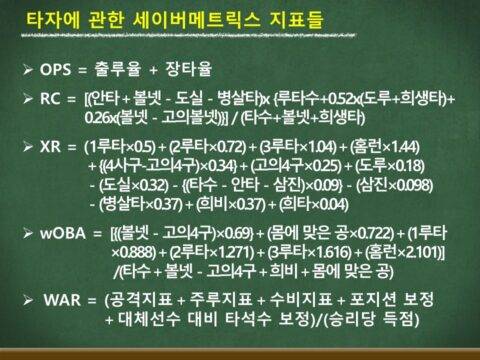

이밖에 세이버메트릭스에서 사용하는 지표들이 위와 같은데 <br> 
나머지 지표도 새롭게 게산하여 열을 추가하고 필요한 열만 추출하도록 한다. 

In [22]:
# RC 추가하기 
RC = (( data['H'] + data['BB'] - data['CS'] - data['GDP'] ) * 
((data['1B'] + data['2B'] + data['3B']) + 
 0.52 * (data['SB'] + data['BU']) +  0.26 * (data['BB'] - data['GB'])))

RC = RC / (data['PA'] + data['BB'] + data['BU'])

In [23]:
RC

0        1.980000
1        2.388387
2        8.125000
3        7.759638
4        0.657391
          ...    
1908    43.000840
1909    18.676328
1910     0.000000
1911    24.825916
1912    45.676090
Length: 1899, dtype: float64

In [24]:
data['RC'] = RC
data

<ipython-input-24-c22d2a8d9824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RC'] = RC


,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,cp,tp,1B,FBP,avg,OBP,SLG,OPS,GPA,RC
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,포수,포수,5.0,6.0,0.173,0.259,0.250,0.509,0.7162,1.980000
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,포수,포수,8.0,5.0,0.177,0.226,0.354,0.580,0.7608,2.388387
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,포수,포수,20.0,20.0,0.234,0.316,0.468,0.784,1.0368,8.125000
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,포수,포수,23.0,20.0,0.195,0.276,0.305,0.581,0.8018,7.759638
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,포수,포수,3.0,3.0,0.176,0.300,0.176,0.476,0.7160,0.657391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3루수,3루수,93.0,59.0,0.301,0.374,0.493,0.867,1.1662,43.000840
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우익수,우익수,44.0,28.0,0.272,0.365,0.319,0.684,0.9760,18.676328
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우익수,우익수,1.0,0.0,0.077,0.077,0.077,0.154,0.2156,0.000000
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,3루수,3루수,57.0,16.0,0.312,0.344,0.505,0.849,1.1242,24.825916


In [25]:
# XR 지표 추가하기
XR = (data['1B']  * 0.5) + (data['2B'] * 0.72) + (data['3B'] * 1.04) + (data['HR'] * 1.44) + ((data['BB'] - data['GB']) * 0.34) + (data['GB'] * 0.25) + (data['SB']*0.18) - (data['CS'] *0.32) - ((data['PA']- data['H'] - data['SO'])*0.09) - (data['SO'] * 0.098) - (data['GDP']*0.37) + (data['fly']*0.37) + (data['BU'] * 0.04)

data['XR'] = XR
data

<ipython-input-25-c7f4355e18d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['XR'] = XR


,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,GPA,RC,XR
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,포수,5.0,6.0,0.173,0.259,0.250,0.509,0.7162,1.980000,1.772
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,포수,8.0,5.0,0.177,0.226,0.354,0.580,0.7608,2.388387,5.906
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,포수,20.0,20.0,0.234,0.316,0.468,0.784,1.0368,8.125000,21.594
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,포수,23.0,20.0,0.195,0.276,0.305,0.581,0.8018,7.759638,12.084
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,포수,3.0,3.0,0.176,0.300,0.176,0.476,0.7160,0.657391,0.226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3루수,93.0,59.0,0.301,0.374,0.493,0.867,1.1662,43.000840,76.986
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우익수,44.0,28.0,0.272,0.365,0.319,0.684,0.9760,18.676328,20.798
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우익수,1.0,0.0,0.077,0.077,0.077,0.154,0.2156,0.000000,-0.990
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,3루수,57.0,16.0,0.312,0.344,0.505,0.849,1.1242,24.825916,43.986


In [26]:
#wOBA 지표 추가 
wOBA = ((data['BB'] - data['GB'] * 0.69) + (data['HBP'] * 0.722) + (data['1B'] * 0.888) + (data['2B']*1.271) + (data['3B'] * 1.616) + (data['HR'] * 2.101)) / (data['PA'] + data['BB'] - data['GB'] + data['fly'] + data['HBP'])
data['wOBA'] = wOBA
data

<ipython-input-26-0d8d5711a20c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['wOBA'] = wOBA


,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,1B,FBP,avg,OBP,SLG,OPS,GPA,RC,XR,wOBA
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,5.0,6.0,0.173,0.259,0.250,0.509,0.7162,1.980000,1.772,0.242563
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,8.0,5.0,0.177,0.226,0.354,0.580,0.7608,2.388387,5.906,0.253297
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,20.0,20.0,0.234,0.316,0.468,0.784,1.0368,8.125000,21.594,0.330590
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,23.0,20.0,0.195,0.276,0.305,0.581,0.8018,7.759638,12.084,0.257986
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,3.0,3.0,0.176,0.300,0.176,0.476,0.7160,0.657391,0.226,0.246261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,93.0,59.0,0.301,0.374,0.493,0.867,1.1662,43.000840,76.986,0.364215
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,44.0,28.0,0.272,0.365,0.319,0.684,0.9760,18.676328,20.798,0.303364
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.077,0.077,0.077,0.154,0.2156,0.000000,-0.990,0.063429
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,57.0,16.0,0.312,0.344,0.505,0.849,1.1242,24.825916,43.986,0.354604


이제 필요한 열만 추출하도록 한다. 

이번 분석에서 필요한 열은 다음과 같다. 

- batter_name : 타자 이름
- age : 나이
- G : 경기 수
- AB : 타석 수
- RBI : 타점
- year : 해당 시즌
- salary : 해당 시즌의 연봉
- war : 대페 선수 대비 승리 기여도
- hand2 : 타석 위치 
- tp : 최종 포지션
- avg : 타율 
- OBP : 출루율 
- SLG : 장타율
- OPS : OBP + SLG
- GPA : 총 생산 평균 (OPS 개선 지표)

In [27]:
# 필요한 열만 추출하기 
data_column = ['batter_name', 'age', 'G', 'AB', 'RBI', 'year', 'salary', 'war', 'hand2', 
               'tp', 'avg', 'OBP', 'SLG', 'OPS', 'GPA', 'RC', 'XR', 'wOBA']

final_data = data[data_column]
final_data

,batter_name,age,G,AB,RBI,year,salary,war,hand2,tp,avg,OBP,SLG,OPS,GPA,RC,XR,wOBA
0,백용환,24.0,26.0,52.0,3.0,2013,2500,-0.055,우투우타,포수,0.173,0.259,0.250,0.509,0.7162,1.980000,1.772,0.242563
1,백용환,25.0,47.0,79.0,10.0,2014,2900,-0.441,우투우타,포수,0.177,0.226,0.354,0.580,0.7608,2.388387,5.906,0.253297
2,백용환,26.0,65.0,154.0,30.0,2015,6000,0.783,우투우타,포수,0.234,0.316,0.468,0.784,1.0368,8.125000,21.594,0.330590
3,백용환,27.0,80.0,174.0,15.0,2016,6000,-0.405,우투우타,포수,0.195,0.276,0.305,0.581,0.8018,7.759638,12.084,0.257986
4,백용환,28.0,15.0,17.0,1.0,2017,5500,-0.130,우투우타,포수,0.176,0.300,0.176,0.476,0.7160,0.657391,0.226,0.246261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,479.0,93.0,2018,30000,3.315,우투우타,3루수,0.301,0.374,0.493,0.867,1.1662,43.000840,76.986,0.364215
1909,조용호,28.0,68.0,191.0,10.0,2017,3100,0.215,우투좌타,우익수,0.272,0.365,0.319,0.684,0.9760,18.676328,20.798,0.303364
1910,조용호,29.0,16.0,13.0,0.0,2018,6200,-0.271,우투좌타,우익수,0.077,0.077,0.077,0.154,0.2156,0.000000,-0.990,0.063429
1911,히메네스,27.0,70.0,279.0,46.0,2015,50000,2.365,우투우타,3루수,0.312,0.344,0.505,0.849,1.1242,24.825916,43.986,0.354604


이제 선수가 몇 명 있는지 확인해본다.

In [28]:
final_data['batter_name'].nunique()

336

In [32]:
name_length = final_data.groupby('batter_name').size()
name_length

batter_name
강경학      5
강동관      1
강동우     13
강민국      3
강민호     15
        ..
황선일      3
황윤호      4
황재균     10
황진수      6
히메네스     2
Length: 336, dtype: int64

총 336명의 선수들이 존재하는 것을 확인할 수 있고 각자의 데이터수가 생각보다 고르지 않는 것을 볼 수 있다.

In [33]:
name_length.median(), name_length.mean()

(4.0, 5.651785714285714)

In [34]:
name_length.min(), name_length.max()

(1, 19)

최소 1번만 출전한 선수가 있고, 최대 19번 출전한 선수도 있다. <br>
중간값으로 4, 평균 5.6이니 대체로 4~6번 출전한 것을 확인할 수 있다.

여기서 생각해 봐야할 것은 선수의 기량 추이를 보기 위해선 1개만으로는 부족하는 것이다. <br>
사실 2개도 부족하다고 봐야할 것이고 각 선수 별로 나이에 따른 증감폭을 확인해야한다. 

하지만 연봉과 기량의 적합도, 상관관계를 구하기 위해서는 1개만이라도 상관이 없다. 

분석하고자하는 각 주제에 대해 데이터셋을 나눠서 가공할 필요가 있다.

# 1. 선수의 기량 추이

선수의 기량을 보기 위해선 선수의 기량이 나이별로 얼마나 되는 지 선그래프로 보면 확인하기 쉬울 것이다.

하지만 총 선수의 수가 336명인 만큼 모두의 그래프를 표시하면 보기 힘들 것이다.

따라서 336명의 나이별 기량 상승을 조사하되 각 연령별로 상승한 인원수를 count 하여 히스토그램으로 표시하면 보기 쉬워질 것이다. 

- 주의사항
    - 기량추이를 보기 위해서는 연봉은 큰 상관이 없기 때문에 전 년도의 data를 기준으로 진행한다.
    - 연령별로 데이터 진행도를 확인해야한다.
    - 출전이 2회 이하인 지표는 제외하도록 한다. 
    - 기량을 전통적 지표 2가지 타율(avg), 타점(RBI) 그리고 세이버 매트릭 GPA와 WAR을 쓰기로 한다. 
    - 두 지표의 상관관계를 보도록 하자.

## 1.1 필요없는 데이터 삭제

In [39]:
# 출전횟수가 2회 이하인 지표는 제외하기 
data1 = final_data.groupby('batter_name').filter(lambda x: x['age'].count() > 2)
data1

,batter_name,age,G,AB,RBI,year,salary,war,hand2,tp,avg,OBP,SLG,OPS,GPA,RC,XR,wOBA
0,백용환,24.0,26.0,52.0,3.0,2013,2500,-0.055,우투우타,포수,0.173,0.259,0.250,0.509,0.7162,1.980000,1.772,0.242563
1,백용환,25.0,47.0,79.0,10.0,2014,2900,-0.441,우투우타,포수,0.177,0.226,0.354,0.580,0.7608,2.388387,5.906,0.253297
2,백용환,26.0,65.0,154.0,30.0,2015,6000,0.783,우투우타,포수,0.234,0.316,0.468,0.784,1.0368,8.125000,21.594,0.330590
3,백용환,27.0,80.0,174.0,15.0,2016,6000,-0.405,우투우타,포수,0.195,0.276,0.305,0.581,0.8018,7.759638,12.084,0.257986
4,백용환,28.0,15.0,17.0,1.0,2017,5500,-0.130,우투우타,포수,0.176,0.300,0.176,0.476,0.7160,0.657391,0.226,0.246261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,이원석,26.0,107.0,325.0,42.0,2012,8400,2.056,우투우타,3루수,0.268,0.337,0.394,0.731,1.0006,22.203883,33.950,0.306778
1905,이원석,27.0,85.0,264.0,39.0,2013,10000,2.810,우투우타,3루수,0.314,0.385,0.473,0.858,1.1660,25.764182,41.838,0.362973
1906,이원석,30.0,7.0,19.0,7.0,2016,15000,0.311,우투우타,3루수,0.316,0.364,0.789,1.153,1.4442,1.318333,4.764,0.436120
1907,이원석,31.0,121.0,411.0,62.0,2017,30000,1.102,우투우타,3루수,0.265,0.323,0.450,0.773,1.0314,28.650221,56.860,0.324395


## 1.2 데이터 길이 확인

In [40]:
age_length = data1.groupby('age').size()
age_length 

age
18.0      7
19.0     60
20.0     64
21.0     61
22.0     73
23.0    121
24.0    133
25.0    140
26.0    145
27.0    146
28.0    147
29.0    133
30.0    109
31.0     94
32.0     81
33.0     68
34.0     50
35.0     34
36.0     29
37.0     20
38.0     10
39.0      6
40.0      5
41.0      2
dtype: int64

In [50]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns

In [101]:
data1.groupby('age').GPA.mean()

age
18.0    0.511400
19.0    0.750003
20.0    0.901306
21.0    0.922282
22.0    0.865321
23.0    0.855339
24.0    0.885256
25.0    0.906224
26.0    0.947091
27.0    0.950777
28.0    0.959737
29.0    0.937662
30.0    1.027787
31.0    1.027719
32.0    0.995706
33.0    1.029450
34.0    1.022132
35.0    1.045406
36.0    1.062697
37.0    1.067490
38.0    1.001200
39.0    1.108367
40.0    1.063040
41.0    0.682400
Name: GPA, dtype: float64

## 1.3 그래프 그리기

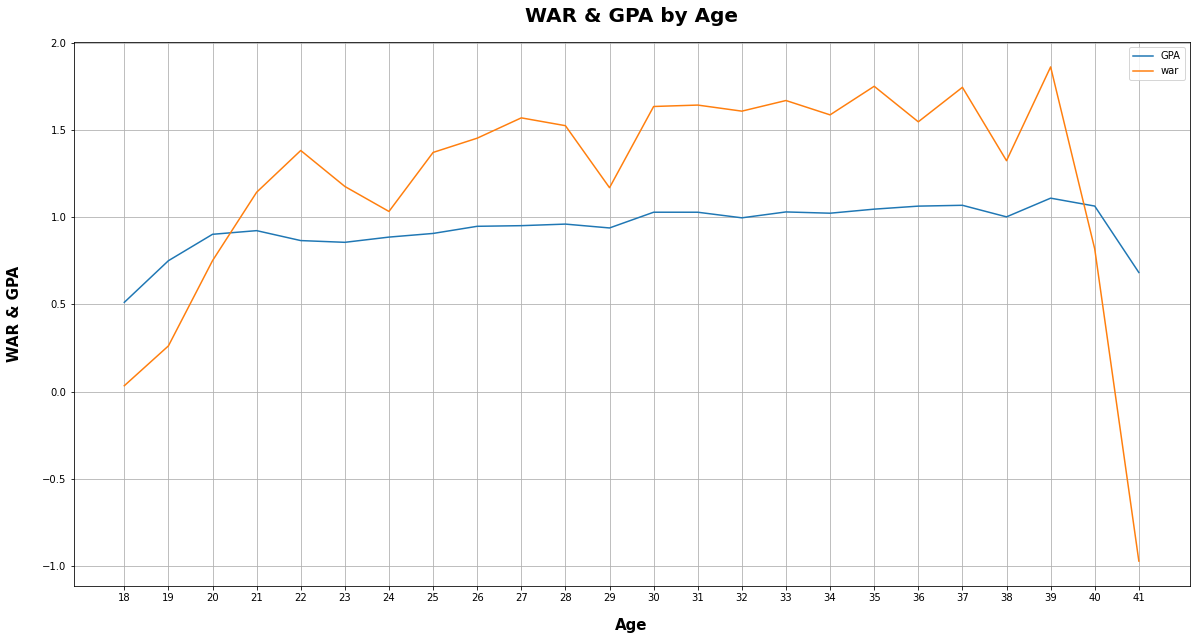

In [138]:

y_gpa = data1.groupby('age').GPA.mean()
y_war = data1.groupby('age').war.mean()
ax= plt.subplots(figsize=(20,10))
ax = y_gpa.plot.line()
ax = y_war.plot.line()

ax.set_title('WAR & GPA by Age', pad=20, fontdict={'weight': 'bold', 'size': 20})
ax.set_xlabel('Age', labelpad=15, fontdict={'weight': 'bold', 'size': 15})
ax.set_ylabel('WAR & GPA', labelpad=20, fontdict={'weight': 'bold', 'size': 15})

plt.xticks(np.arange(18, 42))
plt.grid()
plt.legend()
plt.show()

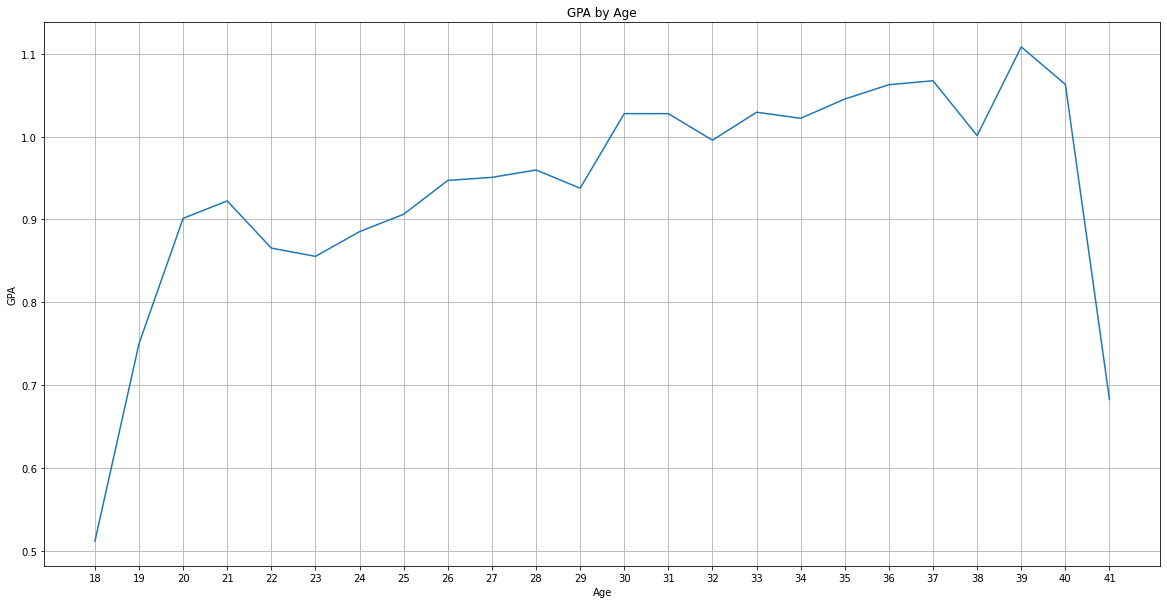

In [126]:
y_gpa = data1.groupby('age').GPA.mean()
ax= plt.subplots(figsize=(20,10)) 
ax = y_gpa.plot.line() 
ax.set_title('GPA by Age') 
ax.set_xlabel('Age') 
ax.set_ylabel('GPA') 
plt.xticks(np.arange(18, 42)) 
plt.grid() 
plt.show()

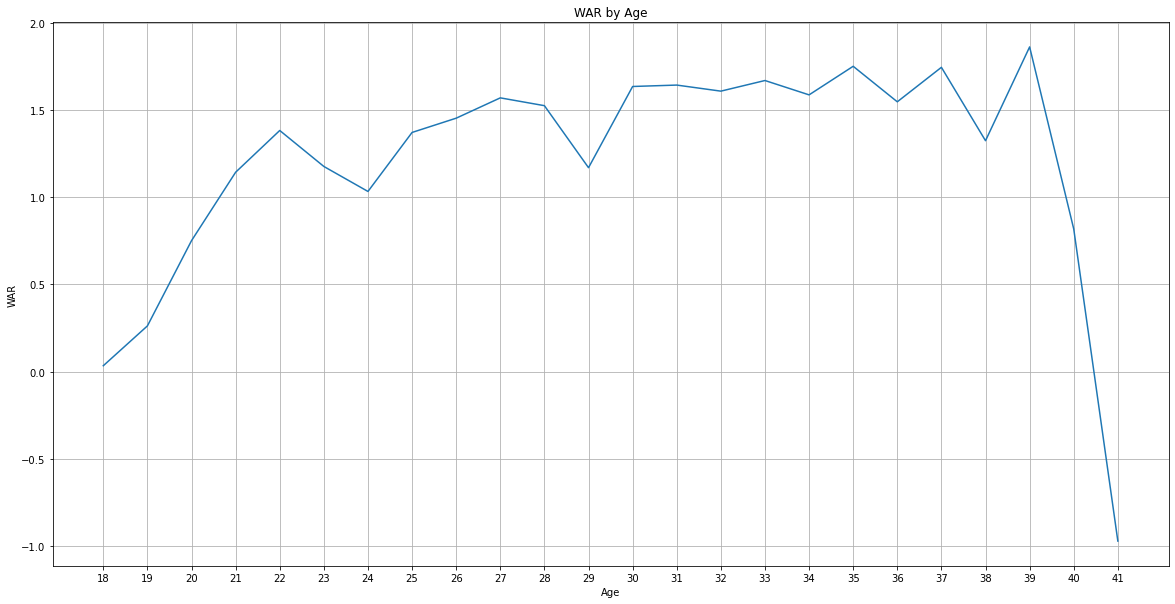

In [128]:
y_war = data1.groupby('age').war.mean()
ax= plt.subplots(figsize=(20,10)) 
ax = y_war.plot.line() 
ax.set_title('WAR by Age') 
ax.set_xlabel('Age') 
ax.set_ylabel('WAR') 
plt.xticks(np.arange(18, 42)) 
plt.grid() 
plt.show()

Text(0.5, 1.0, 'Salary Histogram with Density Plot')

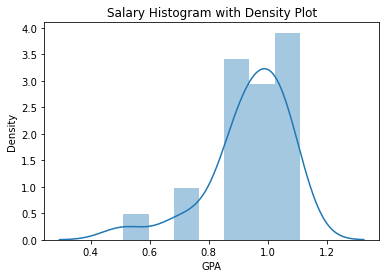

In [54]:
y = data1.groupby('age').GPA.mean().tolist()
x = data1.groupby('age')
ax = plt.subplots() 
ax = sns.distplot(y) 
ax.set_title('Salary Histogram with Density Plot')

(설명 쓰기)

# 2. 선수의 연봉과 기량 적합도

선수가 비슷한 기량을 가지고 있음에도 불구하고 연봉을 더 많이 받거나 적게 받는 경우가 존재할 것이다. 

이번 분석에서는 각 선수의 연봉 추이가 기량과 어떤 상관관계가 있는지<br> 
그리고 기량에 비해 연봉을 덜/많이 받는 선수가 누구인지 확인해볼 것이다.

## 2.1 데이터 추가 전처리

우선 각 연도별 선수 데이터 길이를 확인한다.

In [107]:
final_data[['year' , 'batter_name']].groupby('year').nunique()

,batter_name
year,
1990,8
1991,6
1992,4
1993,4
1994,5
1995,8
1996,12
1997,15
1998,19


In [108]:
year_length = data.groupby('year').size()
year_length.median(), year_length.mean()

(51.0, 65.48275862068965)

타자의 수는 적어도 3백여명인데 보다시피 과거데이터는 턱없이 부족해 대표성이 떨어진다. <br>
주어진 데이터의 중간값, 평균 역시 50~60여명으로 2000년도 이전 데이터는 분석에 큰 도움이 되지 않을 것으로 판단된다. 

따라서 우리는 데이터가 풍족한 최근 10년간의 데이터만을 활용하여 분석을 진행하도록 한다. 

In [153]:
# 최근 10년간의 데이터만 추출하기
data2 = final_data[final_data['year']> 2008]
data2

,batter_name,age,G,AB,RBI,year,salary,war,hand2,tp,avg,OBP,SLG,OPS,GPA,RC,XR,wOBA
0,백용환,24.0,26.0,52.0,3.0,2013,2500,-0.055,우투우타,포수,0.173,0.259,0.250,0.509,0.7162,1.980000,1.772,0.242563
1,백용환,25.0,47.0,79.0,10.0,2014,2900,-0.441,우투우타,포수,0.177,0.226,0.354,0.580,0.7608,2.388387,5.906,0.253297
2,백용환,26.0,65.0,154.0,30.0,2015,6000,0.783,우투우타,포수,0.234,0.316,0.468,0.784,1.0368,8.125000,21.594,0.330590
3,백용환,27.0,80.0,174.0,15.0,2016,6000,-0.405,우투우타,포수,0.195,0.276,0.305,0.581,0.8018,7.759638,12.084,0.257986
4,백용환,28.0,15.0,17.0,1.0,2017,5500,-0.130,우투우타,포수,0.176,0.300,0.176,0.476,0.7160,0.657391,0.226,0.246261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,479.0,93.0,2018,30000,3.315,우투우타,3루수,0.301,0.374,0.493,0.867,1.1662,43.000840,76.986,0.364215
1909,조용호,28.0,68.0,191.0,10.0,2017,3100,0.215,우투좌타,우익수,0.272,0.365,0.319,0.684,0.9760,18.676328,20.798,0.303364
1910,조용호,29.0,16.0,13.0,0.0,2018,6200,-0.271,우투좌타,우익수,0.077,0.077,0.077,0.154,0.2156,0.000000,-0.990,0.063429
1911,히메네스,27.0,70.0,279.0,46.0,2015,50000,2.365,우투우타,3루수,0.312,0.344,0.505,0.849,1.1242,24.825916,43.986,0.354604


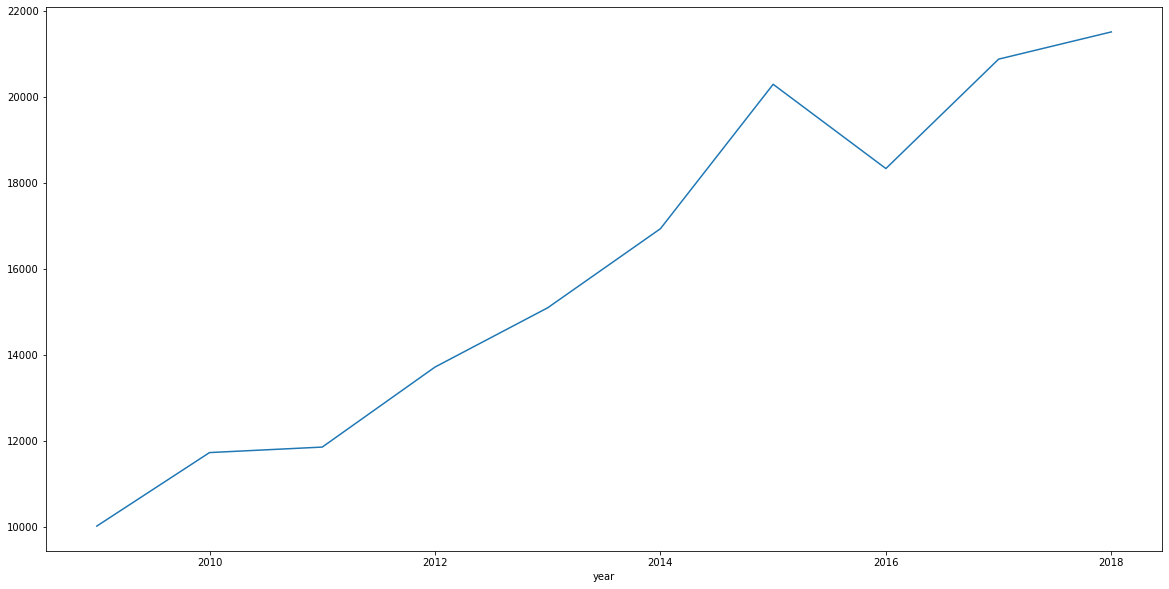

In [130]:
#각 년도의 연봉 대표 지표를 구하기 

# 연도별 연봉 평균
salary_mean = data2.groupby('year').salary.mean()
ax= plt.subplots(figsize=(20,10)) 
ax = salary_mean.plot.line() 
plt.show()

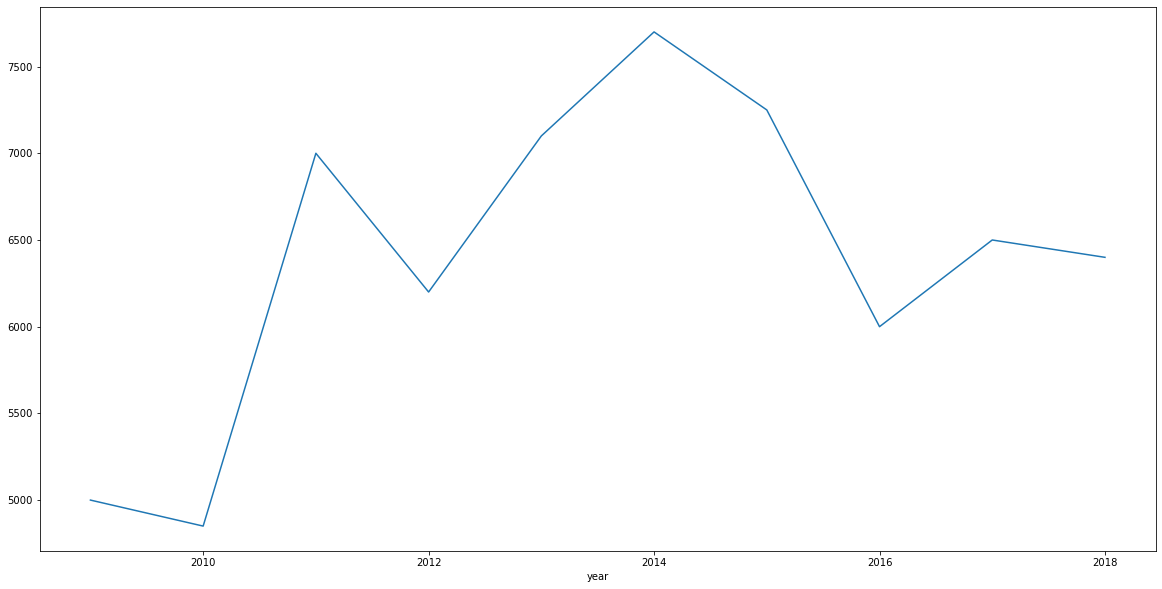

In [131]:

# 연도별 연봉의 중간값 
salary_median = data2.groupby('year').salary.median()
ax= plt.subplots(figsize=(20,10)) 
ax = salary_median.plot.line() 
plt.show()


보다시피 연봉의 연도별 평균 그래프는 계속 상승하고 있으나 <br>
연봉의 연도별 중간값 그래프는 일정 수준에서 오르 내리락 하고 있다. 

이는 무엇을 의미하냐면 
- 베테랑의 연봉은 지속적으로 높아지고 있다.
- 하지만 신입의 연봉은 오히려 적은 경우가 많다. 
- 이에 따라 평균의 함정이 작동되었다.

고 생각할 수 있다.

하나의 기준점으로서 연봉의 기준점을 정하도록 하자. <br>
위 지표를 보면 각 연도의 중간값과 평균값이 차이가 매우 크게 나타난다. 이는 평균의 함정 때문일 것이다.

그렇다면 기량에 비교했을 때 중간값과 평균값 중에 무엇을 사용하면 좋을지 한번 생각해보자.

### 

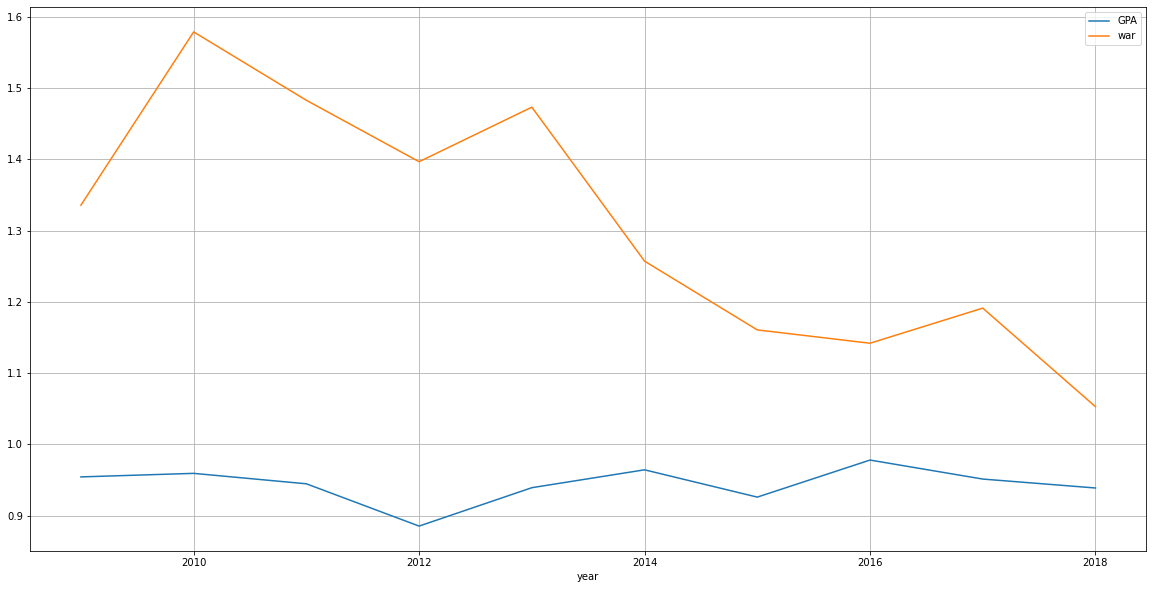

In [139]:
# 연도별 기량 평균
y_gpa = data2.groupby('year').GPA.mean()
y_war = data2.groupby('year').war.mean()

ax= plt.subplots(figsize=(20,10))
ax = y_gpa.plot.line()
ax = y_war.plot.line()

plt.grid()
plt.legend()
plt.show()

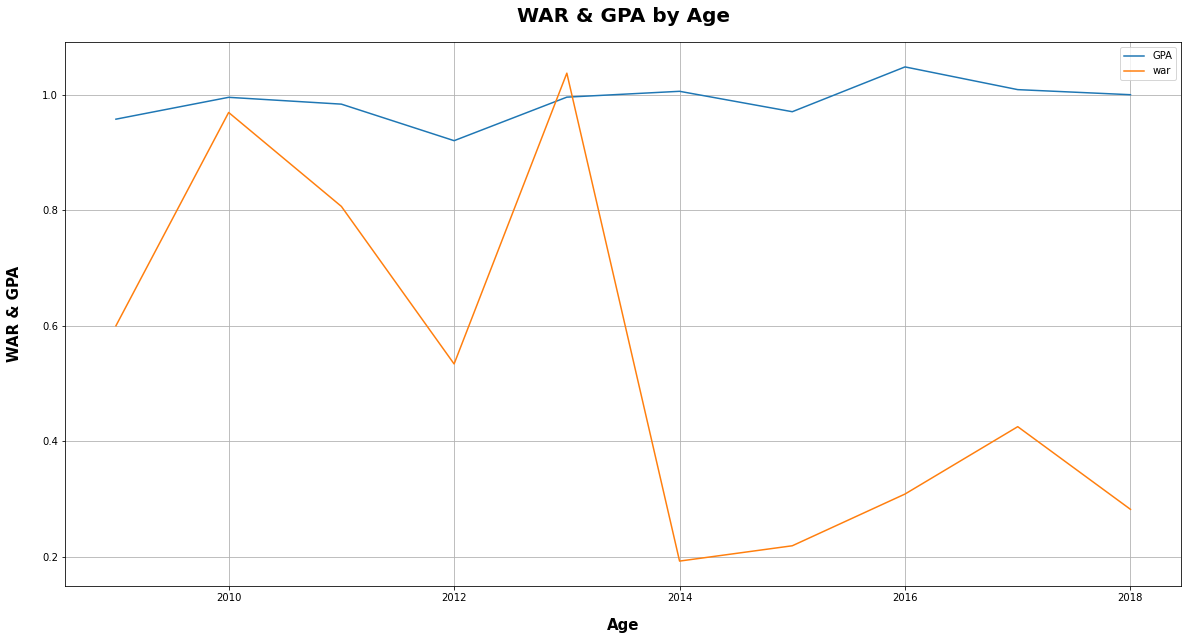

In [154]:
# 연도별 기량 중간값
y_gpa = data2.groupby('year').GPA.median()
y_war = data2.groupby('year').war.median()
ax= plt.subplots(figsize=(20,10))
ax = y_gpa.plot.line()
ax = y_war.plot.line()

ax.set_title('WAR & GPA by Age', pad=20, fontdict={'weight': 'bold', 'size': 20})
ax.set_xlabel('Age', labelpad=15, fontdict={'weight': 'bold', 'size': 15})
ax.set_ylabel('WAR & GPA', labelpad=20, fontdict={'weight': 'bold', 'size': 15})

#plt.xticks(np.arange(18, 42))
plt.grid()
plt.legend()
plt.show()

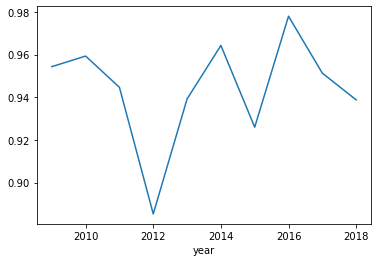
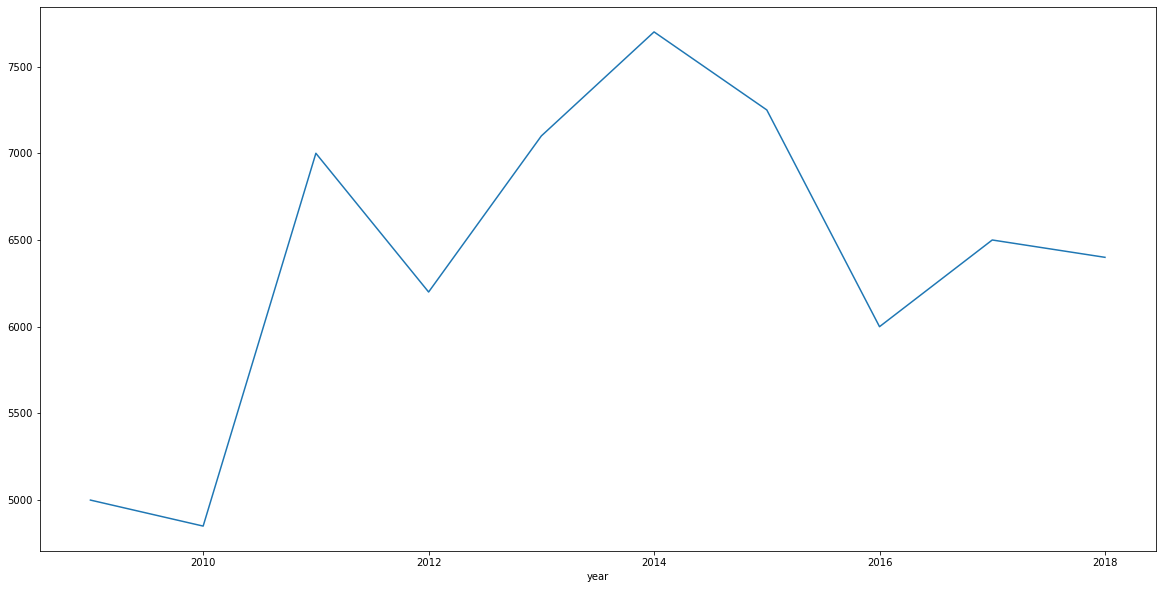

우리는 보통 이런 기대를 가지고 있다. 기량이 높으면 연봉이 증가할 것이란 것이다.

현재 중간 값 그래프가 GPA 중간값 그래프의 양상과 비슷하게 흘러가고 있을 것이므로 <br>
우리는 연봉의 중간값과 기량 GPA 중간값을 같이 가져가는 것이 비교하는 데 쉽게 확인할 수 있을 것이다. 

이때 평균치는 고려하지 않는다. 

In [121]:
data2.groupby('year').war.mean()

year
2009    1.335552
2010    1.578591
2011    1.482660
2012    1.396513
2013    1.473025
2014    1.257023
2015    1.160556
2016    1.141858
2017    1.191115
2018    1.052840
Name: war, dtype: float64

In [ ]:
fig = plt.figure(figsize=(12,2)) 
axes1 = fig.add_subplot(1, 4, 1) 
axes2 = fig.add_subplot(1, 4, 2) 
axes3 = fig.add_subplot(1, 4, 3) 
axes4 = fig.add_subplot(1, 4, 4)

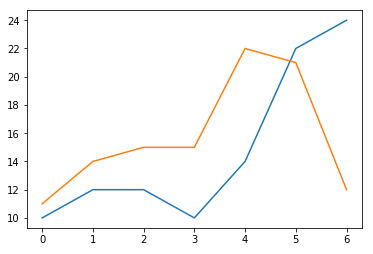

In [112]:
data2.groupby('year').salary.mean()

year
2009    10012.643678
2010    11723.238636
2011    11851.000000
2012    13712.605042
2013    15092.622951
2014    16932.330827
2015    20292.500000
2016    18331.952663
2017    20877.586207
2018    21511.340206
Name: salary, dtype: float64

In [ ]:
salary_mean = data2.groupby('year').salary.mean().tolist()
salary_mean

In [123]:
# 각 연도별 평균 기량 지표 추출
GPA_mean = data2.groupby('year').GPA.mean()
GPA_mean

year
2009    0.954356
2010    0.959318
2011    0.944670
2012    0.885348
2013    0.939211
2014    0.964290
2015    0.925993
2016    0.977982
2017    0.951320
2018    0.938791
Name: GPA, dtype: float64

이 평균 연봉이 하나의 기준선이 될 것이다. 

## 1.2

In [152]:
final_data[final_data['batter_name']=='강민호']

,batter_name,age,G,AB,RBI,year,salary,war,hand2,tp,avg,OBP,SLG,OPS,GPA,RC,XR,wOBA
948,강민호,19.0,3.0,5.0,0.0,2004,2400,-0.126,우투우타,포수,0.000,0.000,0.000,0.000,0.0000,0.000000,-0.524,0.000000
949,강민호,20.0,104.0,214.0,18.0,2005,2000,0.207,우투우타,포수,0.243,0.267,0.341,0.608,0.8216,10.651639,13.282,0.256181
950,강민호,21.0,126.0,410.0,53.0,2006,3500,2.629,우투우타,포수,0.251,0.307,0.366,0.673,0.9186,26.274447,39.096,0.282597
951,강민호,22.0,125.0,413.0,68.0,2007,8000,3.316,우투우타,포수,0.271,0.335,0.421,0.756,1.0240,29.843182,49.756,0.315853
952,강민호,23.0,122.0,435.0,82.0,2008,10000,5.372,우투우타,포수,0.292,0.365,0.485,0.850,1.1420,35.130327,67.664,0.352456
953,강민호,24.0,83.0,262.0,30.0,2009,14500,1.796,우투우타,포수,0.260,0.346,0.412,0.758,1.0348,18.543234,32.908,0.326714
954,강민호,25.0,117.0,410.0,72.0,2010,13500,5.040,우투우타,포수,0.305,0.376,0.524,0.900,1.2008,32.293491,65.960,0.373776
955,강민호,26.0,124.0,450.0,66.0,2011,20000,5.385,우투우타,포수,0.289,0.366,0.480,0.846,1.1388,34.523219,63.262,0.358775
956,강민호,27.0,119.0,400.0,66.0,2012,30000,4.996,우투우타,포수,0.272,0.355,0.468,0.823,1.1070,28.979036,57.024,0.348375
957,강민호,28.0,105.0,327.0,57.0,2013,55000,3.092,우투우타,포수,0.235,0.366,0.376,0.742,1.0348,23.450687,42.424,0.318518


## 1.3

In [106]:
final_data[['year' , 'salary']].groupby('salary').nunique()

,year
salary,
1700,2
1800,4
1900,2
2000,12
2100,8
...,...
125000,1
140000,1
150000,5


In [128]:
final_data[['batter_name','year' , 'salary']].groupby([ 'salary', 'year']).nunique().unstack().head(n=100)

batter_name                                                ...        \
year          1990 1991 1992 1993 1994 1995  1996 1997 1998 1999  ...  2009   
salary                                                            ...         
1700           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
1800           NaN  NaN  NaN  NaN  NaN  NaN   NaN  1.0  NaN  NaN  ...   NaN   
1900           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
2000           NaN  NaN  NaN  NaN  NaN  NaN   NaN  4.0  NaN  NaN  ...   3.0   
2100           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  NaN  ...   2.0   
2200           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  1.0  ...   4.0   
2300           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   4.0   
2400           8.0  6.0  4.0  4.0  5.0  8.0  12.0  4.0  6.0  5.0  ...  12.0   
2470           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
2500           NaN  NaN  NaN  NaN  NaN  NaN   NaN  1.0  NaN  NaN  ...   3.0   
2600           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  1.0  ...   NaN   
2700           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
2800           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  NaN  ...   NaN   
2900           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  1.0  ...   NaN   
3000           NaN  NaN  NaN  NaN  NaN  NaN   NaN  1.0  1.0  2.0  ...   2.0   
3100           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
3200           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  1.0  ...   1.0   
3300           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   1.0   
3400           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
3500           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  NaN  ...   2.0   
3600           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  NaN  ...   NaN   
3700           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  NaN  ...   NaN   
3800           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  1.0  NaN  ...   1.0   
4000           NaN  NaN  NaN  NaN  NaN  NaN   NaN  1.0  1.0  1.0  ...   3.0   
4095           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
4100           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
4200           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   3.0   
4250           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
4300           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   NaN   
4400           NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN  ...   2.0   

                                                              
year    2010  2011  2012  2013  2014  2015  2016  2017  2018  
salary                                                        
1700     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1800     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1900     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2000     1.0   NaN   NaN   NaN   1.0   NaN   NaN   NaN   NaN  
2100     1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2200     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2300     2.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2400    15.0  14.0  22.0  20.0  15.0   3.0   2.0   7.0   3.0  
2470     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2500     1.0   3.0   5.0   5.0   5.0   NaN   1.0   NaN   NaN  
2600     1.0   5.0   4.0   2.0   2.0   NaN   NaN   NaN   NaN  
2700     1.0   4.0   NaN   NaN   3.0   7.0  22.0  14.0  19.0  
2800     1.0   NaN   1.0   NaN   3.0   1.0   6.0   5.0   9.0  
2900     NaN   NaN   NaN   NaN   4.0   3.0   3.0   3.0   6.0  
3000     4.0   1.0   4.0   3.0   NaN  15.0  11.0  13.0   9.0  
3100     NaN   1.0   1.0   NaN   1.0   NaN   NaN   4.0   2.0  
3200     NaN   2.0   1.0   1.0   NaN   4.0   3.0   NaN   3.0  
3300     3.0   1.0   NaN   1.0   NaN   5.0   5.0   1.0   5.0  
3400     NaN   NaN   NaN   1.0   2.0   NaN   1.0   NaN   NaN  
3500     4.0 

In [108]:
final_data[['batter_name','year' , 'salary']].sort_values(by= 'year')

,batter_name,year,salary
1438,전종화,1990,2400
1508,이광길,1990,2400
1436,심재원,1990,2400
1578,장효조,1990,2400
1530,김병수,1990,2400
...,...,...,...
1414,허일,2018,2700
1708,박병호,2018,150000
1710,박준태,2018,3800
1685,김태균,2018,160000


In [141]:
final_data['batter_name' ==  '이정후']

KeyError: False

In [28]:
length.median(), length.mean()

(51.0, 65.96551724137932)

In [32]:
length.quantile(0.1)

5.800000000000001

In [26]:
data[data['year']>=2000]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,...,tp,1B,FBP,avg,OBP,SLG,OPS,p_year,YAB,YOPS
0,백용환,24.0,26.0,58.0,52.0,4.0,9.0,4.0,0.0,0.0,...,포수,5.0,6.0,0.173,0.259,0.250,0.509,2014,79.0,0.580
1,백용환,25.0,47.0,86.0,79.0,8.0,14.0,2.0,0.0,4.0,...,포수,8.0,5.0,0.177,0.226,0.354,0.580,2015,154.0,0.784
2,백용환,26.0,65.0,177.0,154.0,22.0,36.0,6.0,0.0,10.0,...,포수,20.0,20.0,0.234,0.316,0.468,0.784,2016,174.0,0.581
3,백용환,27.0,80.0,199.0,174.0,12.0,34.0,7.0,0.0,4.0,...,포수,23.0,20.0,0.195,0.276,0.305,0.581,2017,17.0,0.476
4,백용환,28.0,15.0,20.0,17.0,2.0,3.0,0.0,0.0,0.0,...,포수,3.0,3.0,0.176,0.300,0.176,0.476,2018,47.0,0.691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,이원석,32.0,128.0,543.0,479.0,74.0,144.0,30.0,1.0,20.0,...,3루수,93.0,59.0,0.301,0.374,0.493,0.867,2019,395.0,0.768
1909,조용호,28.0,68.0,225.0,191.0,34.0,52.0,7.0,1.0,0.0,...,우익수,44.0,28.0,0.272,0.365,0.319,0.684,2018,13.0,0.154
1910,조용호,29.0,16.0,14.0,13.0,4.0,1.0,0.0,0.0,0.0,...,우익수,1.0,0.0,0.077,0.077,0.077,0.154,2019,188.0,0.720
1911,히메네스,27.0,70.0,299.0,279.0,37.0,87.0,17.0,2.0,11.0,...,3루수,57.0,16.0,0.312,0.344,0.505,0.849,2016,523.0,0.889


In [22]:
data.groupby('tp').size() - data.groupby('cp').size()

tp
1루수     -25
2루수      21
3루수     -30
우익수      30
유격수     103
좌익수      19
중견수      60
지명타자   -195
포수       17
dtype: int64

In [21]:
data.groupby('cp').size()

cp
1루수     212
2루수     213
3루수     243
우익수     200
유격수     135
좌익수     240
중견수     172
지명타자    268
포수      230
dtype: int64

In [25]:
data.loc[32]

batter_name           안치홍
age                  26.0
G                    10.0
PA                   43.0
AB                   36.0
R                     3.0
H                     8.0
2B                    2.0
3B                    0.0
HR                    0.0
TB                   10.0
RBI                   1.0
SB                    0.0
CS                    0.0
BB                    5.0
HBP                   0.0
GB                    0.0
SO                    8.0
GDP                   2.0
BU                    1.0
fly                   1.0
year                 2016
salary              15000
war                -0.124
year_born      1990-07-02
hand2                우투우타
cp                    2루수
tp                    2루수
1B                    6.0
FBP                   5.0
avg                 0.222
OBP                  0.31
SLG                 0.278
OPS                 0.588
p_year               2017
YAB                 487.0
YOPS                0.886
Name: 32, dtype: object